# FINAL REPORT

# DSCI 5240 DATA MINING (WATER PUMP FUNCTIONALITY PREDICTION) GROUP 3

SNEHA MISHRA

BIMALA PANT

ROHITH REDDY

VARUN KUMAR CHETUKURI

#IMPORT LIBRARIES

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


# LOAD CLEANED DATA

In [52]:
df_clean = pd.read_csv('Cleaned_Water_Pump_Data .csv')

print(f"Dataset Shape: {df_clean.shape}")
print(f"\nColumns: {list(df_clean.columns)}")
print("\nFirst 5 rows:")
print(df_clean.head())

Dataset Shape: (5000, 12)

Columns: ['Water Pump ID', 'Water Source Type', 'Water Quality', 'Distance to Nearest Town', 'Population Served', 'Installation Year', 'Funder', 'Payment Type', 'Water Pump Age', 'Pump Type', 'GPS Coordinates', 'Functioning Status']

First 5 rows:
  Water Pump ID Water Source Type Water Quality  Distance to Nearest Town  \
0         WP001              Lake  Contaminated                      47.0   
1         WP002           Unknown       Unknown                      38.0   
2         WP003              Lake  Contaminated                      46.0   
3         WP004              Well         Clean                      56.0   
4         WP005              Well  Contaminated                      35.0   

   Population Served  Installation Year   Funder Payment Type  Water Pump Age  \
0            24000.0             2009.0    Oxfam         Free            16.0   
1            20000.0             2020.0  Unknown         Free             5.0   
2            26000.

We load the dataset that was already cleaned in the update report. This dataset has undergone exploratory data analysis and initial preprocessing.

# SUMMARY STATISTICS

In [54]:

df = pd.read_csv('Cleaned_Water_Pump_Data .csv')
# Numerical features
num_cols = df.select_dtypes(include=[np.number]).columns
num_summary = df[num_cols].describe().T[['mean', 'min', 'max']].round(2)
num_summary['range'] = (num_summary['max'] - num_summary['min']).round(2)
print("NUMERICAL FEATURES:")
print(num_summary)
num_summary.to_csv('numerical_stats.csv')

# Categorical features
cat_cols = df.select_dtypes(include=['object']).columns
print("\nCATEGORICAL FEATURES:")
for col in cat_cols:
    print(f"\n{col}:")
    freq = df[col].value_counts()
    print(freq.head())

NUMERICAL FEATURES:
                              mean      min      max    range
Distance to Nearest Town     40.93     18.0     60.0     42.0
Population Served         23756.80  14000.0  35000.0  21000.0
Installation Year          2004.81   1990.0   2020.0     30.0
Water Pump Age               20.19      5.0     35.0     30.0

CATEGORICAL FEATURES:

Water Pump ID:
Water Pump ID
Unknown    870
WP3317       1
WP3316       1
WP3313       1
WP3312       1
Name: count, dtype: int64

Water Source Type:
Water Source Type
Well        2456
Lake        1129
Unknown      805
Borehole     388
River        222
Name: count, dtype: int64

Water Quality:
Water Quality
Contaminated    3050
Clean           1263
Unknown          687
Name: count, dtype: int64

Funder:
Funder
Red Cross    1866
USAID        1337
Unknown       691
Oxfam         606
UNICEF        439
Name: count, dtype: int64

Payment Type:
Payment Type
Free           2945
Pay per use    1436
Unknown         619
Name: count, dtype: int64

P

# TARGET DISTRIBUTION BEFORE CLEANING

In [25]:
# Check target distribution before cleaning
print("\n" + "="*70)
print("Target Variable Distribution (Before Cleaning):")
print("="*70)
print(df_clean['Functioning Status'].value_counts())
print(f"\nPercentages:")
print(df_clean['Functioning Status'].value_counts(normalize=True) * 100)


Target Variable Distribution (Before Cleaning):
Functioning Status
Not Functioning    3632
Functioning         989
Unknown             379
Name: count, dtype: int64

Percentages:
Functioning Status
Not Functioning    72.64
Functioning        19.78
Unknown             7.58
Name: proportion, dtype: float64


# REMOVE TARGET VARIABLE 'UNKNOWN' VALUES

In [26]:
# Remove 'Unknown' values from target
df_modeling = df_clean[df_clean['Functioning Status'] != 'Unknown'].copy()

print(f"\n{'='*70}")
print(f"Rows removed: {len(df_clean) - len(df_modeling)}")
print(f"Final dataset shape: {df_modeling.shape}")
print(f"{'='*70}")

print("\nTarget Variable Distribution (After Cleaning):")
print(df_modeling['Functioning Status'].value_counts())
print(f"\nPercentages:")
print(df_modeling['Functioning Status'].value_counts(normalize=True) * 100)


Rows removed: 379
Final dataset shape: (4621, 12)

Target Variable Distribution (After Cleaning):
Functioning Status
Not Functioning    3632
Functioning         989
Name: count, dtype: int64

Percentages:
Functioning Status
Not Functioning    78.597706
Functioning        21.402294
Name: proportion, dtype: float64


Observation: The target variable contains 'Unknown' values which cannot be used for supervised learning. Classification algorithms require known labels to learn patterns.

# VISUALIZE TARGET VARIABLE DISTRIBUTION

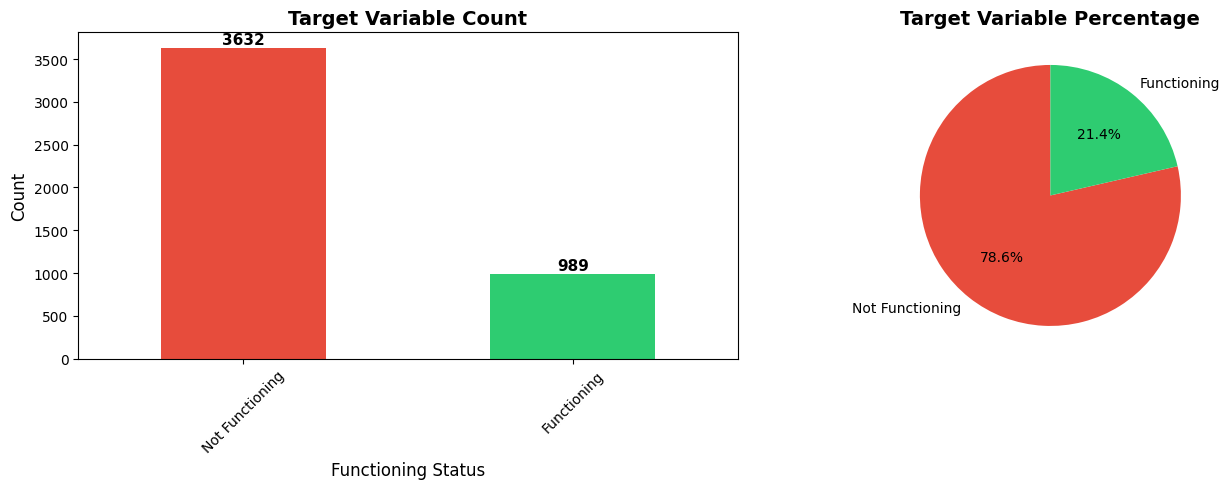


⚠️ Class Imbalance Ratio: 3.67:1


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df_modeling['Functioning Status'].value_counts().plot(
    kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71']
)
axes[0].set_title('Target Variable Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Functioning Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

for i, v in enumerate(df_modeling['Functioning Status'].value_counts()):
    axes[0].text(i, v + 50, str(v), ha='center', fontsize=11, fontweight='bold')

# Pie chart
df_modeling['Functioning Status'].value_counts().plot(
    kind='pie', ax=axes[1], autopct='%1.1f%%',
    colors=['#e74c3c', '#2ecc71'], startangle=90
)
axes[1].set_title('Target Variable Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

counts = df_modeling['Functioning Status'].value_counts()
ratio = counts.iloc[0] / counts.iloc[1]
print(f"\n⚠️ Class Imbalance Ratio: {ratio:.2f}:1")

Observation: We visualize the target variable to understand class distribution. The dataset shows significant class imbalance with 78.6% Not Functioning and 21.4% Functioning pumps.

# Feature Engineering

In [28]:
df_features = df_modeling.copy()

# 1. Extract Latitude and Longitude from GPS Coordinates
def extract_coordinates(coord_str):
    """Extract latitude and longitude from GPS coordinate string"""
    if coord_str == 'Unknown' or pd.isna(coord_str):
        return np.nan, np.nan
    try:
        coords = coord_str.strip('()').split(',')
        lat = float(coords[0])
        lon = float(coords[1])
        return lat, lon
    except:
        return np.nan, np.nan

df_features[['Latitude', 'Longitude']] = df_features['GPS Coordinates'].apply(
    lambda x: pd.Series(extract_coordinates(x))
)

df_features['Latitude'].fillna(df_features['Latitude'].median(), inplace=True)
df_features['Longitude'].fillna(df_features['Longitude'].median(), inplace=True)

# 2. Create binary indicators for 'Unknown' categorical values
unknown_cols = ['Water Source Type', 'Water Quality', 'Funder', 'Payment Type', 'Pump Type']
for col in unknown_cols:
    df_features[f'{col}_Missing'] = (df_features[col] == 'Unknown').astype(int)

# 3. Create Population Density
df_features['Population_Density'] = (
    df_features['Population Served'] / df_features['Distance to Nearest Town']
)

print("\n" + "="*70)
print("✓ Feature Engineering Complete!")
print("="*70)
print(f"New dataset shape: {df_features.shape}")


✓ Feature Engineering Complete!
New dataset shape: (4621, 20)


Observation: Created 8 new features: 2 from GPS coordinates, 5 missing indicators, and 1 derived population density feature. This increases our feature space from 12 to 20 features.

# PREPARE FEATURES FOR MODELING

In [29]:
# Drop ID columns and target variable
features_to_drop = ['Water Pump ID', 'GPS Coordinates', 'Functioning Status']
X = df_features.drop(columns=features_to_drop)
y = df_features['Functioning Status']

print("\n" + "="*70)
print("Feature Preparation")
print("="*70)
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures selected for modeling ({len(X.columns)} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

# Encode target variable (Functioning=0, Not Functioning=1)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"\nTarget Variable Encoding:")
for i, label in enumerate(le_target.classes_):
    print(f"  {label} -> {i}")
print(f"\nEncoded target distribution:")
print(pd.Series(y_encoded).value_counts())


Feature Preparation
Feature matrix shape: (4621, 17)
Target vector shape: (4621,)

Features selected for modeling (17 total):
  1. Water Source Type
  2. Water Quality
  3. Distance to Nearest Town
  4. Population Served
  5. Installation Year
  6. Funder
  7. Payment Type
  8. Water Pump Age
  9. Pump Type
  10. Latitude
  11. Longitude
  12. Water Source Type_Missing
  13. Water Quality_Missing
  14. Funder_Missing
  15. Payment Type_Missing
  16. Pump Type_Missing
  17. Population_Density

Target Variable Encoding:
  Functioning -> 0
  Not Functioning -> 1

Encoded target distribution:
1    3632
0     989
Name: count, dtype: int64


Observation: We separate the features (X) from the target variable (y) and encode the target as numeric values. We drop identifier columns that don't contribute to predictions.

# ENCODE CATEGORICAL VARIABLES

In [30]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print("\n" + "="*70)
print("Categorical Variable Encoding")
print("="*70)
print(f"Categorical columns to encode: {categorical_cols}")

# Label encode each categorical column
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

    print(f"\n{col} encoding:")
    for i, label in enumerate(le.classes_):
        print(f"  {label} -> {i}")

print(f"\n✓ All categorical variables encoded!")
print(f"Encoded feature matrix shape: {X_encoded.shape}")
print(f"Data types after encoding:")
print(X_encoded.dtypes.value_counts())


Categorical Variable Encoding
Categorical columns to encode: ['Water Source Type', 'Water Quality', 'Funder', 'Payment Type', 'Pump Type']

Water Source Type encoding:
  Borehole -> 0
  Lake -> 1
  River -> 2
  Unknown -> 3
  Well -> 4

Water Quality encoding:
  Clean -> 0
  Contaminated -> 1
  Unknown -> 2

Funder encoding:
  Oxfam -> 0
  Red Cross -> 1
  UNICEF -> 2
  USAID -> 3
  Unknown -> 4
  World Bank -> 5

Payment Type encoding:
  Free -> 0
  Pay per use -> 1
  Unknown -> 2

Pump Type encoding:
  Hand Pump -> 0
  Motorized Pump -> 1
  Solar Pump -> 2
  Unknown -> 3

✓ All categorical variables encoded!
Encoded feature matrix shape: (4621, 17)
Data types after encoding:
int64      10
float64     7
Name: count, dtype: int64


Observation: We use label encoding to convert categorical text variables (like Water Source Type,
Funder, etc.) into numeric codes.

# TRAIN-TEST SPLIT (70/30)

In [31]:
print("\n" + "="*70)
print("Train-Test Split (70/30)")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples (70%)")
print(f"Testing set: {X_test.shape[0]} samples (30%)")
print(f"\nTraining class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTesting class distribution:")
print(pd.Series(y_test).value_counts())



Train-Test Split (70/30)
Training set: 3234 samples (70%)
Testing set: 1387 samples (30%)

Training class distribution:
1    2542
0     692
Name: count, dtype: int64

Testing class distribution:
1    1090
0     297
Name: count, dtype: int64


Observation: We split the data into 70% for training and 30% for testing(validation). Stratified splitting ensures both sets maintain the sameclass distribution.

# FEATURE SCALING (STANDARDIZATION)

In [32]:
print("\n" + "="*70)
print("Feature Scaling (Standardization)")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("All features scaled to mean=0, std=1")
print("This ensures equal contribution from all features")


Feature Scaling (Standardization)
All features scaled to mean=0, std=1
This ensures equal contribution from all features


Observation : We standardize all features to have mean=0 and standard deviation=1. Scaling ensures all features contribute equally to the model.

# HANDLE CLASS IMBALANCE

In [13]:
print("\n" + "="*70)
print("Class Imbalance Handling")
print("="*70)

# Strategy 1: Original (Imbalanced)
X_train_original = X_train_scaled
y_train_original = y_train

# Strategy 2: SMOTE Over-sampling
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Strategy 3: Random Under-sampling
undersample = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_under, y_train_under = undersample.fit_resample(X_train_scaled, y_train)

print("✓ Three datasets created for testing")


Class Imbalance Handling
✓ Three datasets created for testing


Observation: With 78.6% Not Functioning vs 21.4% Functioning, models may ignore the minority class.We create three training dataset versions:
1. Original (imbalanced) - for models with built-in class weights
2. SMOTE (over-sampling) - creates synthetic minority class samples
3. Under-sampling - reduces majority class samples

# MODEL EVALUATION FUNCTION

In [33]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train and evaluate a classification model.
    Returns dictionary with all evaluation metrics.
    """
    print(f"\nTraining {model_name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    print(f"Test Accuracy:  {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC:        {roc_auc:.4f}")
    print(f"CV Accuracy:    {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'predictions': y_pred,
        'pred_proba': y_pred_proba
    }

print("\n" + "="*70)
print("Model Evaluation Function Defined")
print("="*70)


Model Evaluation Function Defined


Observation: We create a reusable function to train and evaluate models consistently. It calculates multiple metrics: accuracy, precision, recall,F1-score, ROC AUC, and performs 5-fold cross-validation.

# ALGORITHM 1 - LOGISTIC REGRESSION

In [34]:

print("\n" + "="*70)
print("ALGORITHM 1: LOGISTIC REGRESSION")
print("="*70)

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000
)

lr_results = evaluate_model(
    lr_model, X_train_smote, y_train_smote, X_test_scaled, y_test,
    "Logistic Regression"
)



ALGORITHM 1: LOGISTIC REGRESSION

Training Logistic Regression...

Logistic Regression
Test Accuracy:  0.6792
Precision:      0.7773
Recall:         0.6792
F1-Score:       0.7063
ROC AUC:        0.7447
CV Accuracy:    0.6926 (+/- 0.0268)

Confusion Matrix:
[[205  92]
 [353 737]]


Observation – Logistic Regression

The Logistic Regression model performed reasonably well on this dataset. The test accuracy is 67.92%, showing that the model correctly predicts about two-thirds of the cases. Precision is high (77.73%), meaning when the model predicts a positive case, it is usually correct. However, recall (67.92%) indicates that the model still misses some positive cases. The F1-score (70.63%) shows a balanced performance between precision and recall. The ROC AUC value (0.7447) suggests the model has a good ability to separate the two classes. Cross-validation accuracy (69.26%) is close to the test accuracy, which means the model is stable and does not overfit. Overall, Logistic Regression provides a solid baseline model for this classification problem.

# ALGORITHM 2 - RANDOM FOREST WITH HYPERPARAMETER TUNING

In [38]:
print("\n" + "="*70)
print("ALGORITHM 2: RANDOM FOREST (with Hyperparameter Tuning)")
print("="*70)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20, 25],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}

rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Starting hyperparameter tuning...")
print(f"Testing {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf'])} parameter combinations")

grid_search_rf = GridSearchCV(
    rf_model,
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_original, y_train_original)

print(f"\nBest parameters found: {grid_search_rf.best_params_}")
print(f"Best cross-validation score: {grid_search_rf.best_score_:.4f}")

rf_results = evaluate_model(
    grid_search_rf.best_estimator_, X_train_original, y_train_original,
    X_test_scaled, y_test,
    "Random Forest (Optimized)"
)


ALGORITHM 2: RANDOM FOREST (with Hyperparameter Tuning)
Starting hyperparameter tuning...
Testing 24 parameter combinations
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.7743

Training Random Forest (Optimized)...

Random Forest (Optimized)
Test Accuracy:  0.7902
Precision:      0.7653
Recall:         0.7902
F1-Score:       0.7716
ROC AUC:        0.7770
CV Accuracy:    0.7743 (+/- 0.0111)

Confusion Matrix:
[[ 97 200]
 [ 91 999]]


Observation – Random Forest

The optimized Random Forest model shows strong performance compared to the baseline model. It achieves a test accuracy of 79.02%, indicating that it correctly classifies most cases. The recall (79.02%) is higher than precision (76.53%), meaning the model is good at identifying positive cases but makes some false positives. The F1-score of 77.16% reflects a balanced trade-off between precision and recall. The ROC AUC value (0.7770) shows that the model separates the classes well. The cross-validation accuracy (77.43%) is close to the test accuracy, suggesting that the model generalizes well and is not overfitting. Overall, the optimized Random Forest provides a strong and reliable model for this classification task.

# ALGORITHM 3 - GRADIENT BOOSTING WITH HYPERPARAMETER TUNING

In [16]:
print("\n" + "="*70)
print("ALGORITHM 3: GRADIENT BOOSTING (with Hyperparameter Tuning)")
print("="*70)

param_grid_gb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 5, 6],
    'min_samples_split': [10, 20]
}

gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

print("Starting hyperparameter tuning...")
print(f"Testing {len(param_grid_gb['n_estimators']) * len(param_grid_gb['learning_rate']) * len(param_grid_gb['max_depth']) * len(param_grid_gb['min_samples_split'])} parameter combinations")

grid_search_gb = GridSearchCV(
    gb_model,
    param_grid_gb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train_smote, y_train_smote)

print(f"\nBest parameters found: {grid_search_gb.best_params_}")
print(f"Best cross-validation score: {grid_search_gb.best_score_:.4f}")

gb_results = evaluate_model(
    grid_search_gb.best_estimator_, X_train_smote, y_train_smote,
    X_test_scaled, y_test,
    "Gradient Boosting (Optimized)"
)


ALGORITHM 3: GRADIENT BOOSTING (with Hyperparameter Tuning)
Starting hyperparameter tuning...
Testing 24 parameter combinations
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 150}
Best cross-validation score: 0.8446

Training Gradient Boosting (Optimized)...

Gradient Boosting (Optimized)
Test Accuracy:  0.7880
Precision:      0.7761
Recall:         0.7880
F1-Score:       0.7810
ROC AUC:        0.7764
CV Accuracy:    0.8446 (+/- 0.1207)

Confusion Matrix:
[[126 171]
 [123 967]]


Observation – Gradient Boosting

The optimized Gradient Boosting model performs well, achieving a test accuracy of 78.80%, which is close to the Random Forest performance. Precision (77.61%) and recall (78.80%) are balanced, indicating that the model is good at identifying positive cases while keeping false positives controlled. The F1-score of 78.10% shows a strong overall classification ability. The ROC AUC value (0.7764) suggests that the model separates the classes effectively. However, the cross-validation accuracy (84.46%) is noticeably higher than the test accuracy, indicating that the model may be slightly overfitting or performing better on the training folds than on unseen data. Despite this, Gradient Boosting still delivers competitive performance and captures complex patterns in the dataset.

# ALGORITHM 4 - K-NEAREST NEIGHBORS

In [17]:
print("\n" + "="*70)
print("ALGORITHM 4: K-NEAREST NEIGHBORS")
print("="*70)

knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn_results = evaluate_model(
    knn_model, X_train_smote, y_train_smote, X_test_scaled, y_test,
    "K-Nearest Neighbors"
)



ALGORITHM 4: K-NEAREST NEIGHBORS

Training K-Nearest Neighbors...

K-Nearest Neighbors
Test Accuracy:  0.6229
Precision:      0.7262
Recall:         0.6229
F1-Score:       0.6549
ROC AUC:        0.6469
CV Accuracy:    0.7669 (+/- 0.0123)

Confusion Matrix:
[[167 130]
 [393 697]]


Observation – K-Nearest Neighbors

The K-Nearest Neighbors (KNN) model shows weaker performance compared to the other algorithms. It achieves a test accuracy of 62.29%, which is noticeably lower than Logistic Regression, Random Forest, and Gradient Boosting. Although the precision (72.62%) is relatively good—meaning it is fairly accurate when it predicts positive cases—the recall (62.29%) and F1-score (65.49%) indicate that the model struggles to correctly identify many positive samples. The ROC AUC value (0.6469) also shows limited ability to separate the two classes. Interestingly, the cross-validation accuracy (76.69%) is much higher than the test accuracy, suggesting potential overfitting, where the model performs better on training folds but does not generalize well to unseen data.

# ALGORITHM 5 - SUPPORT VECTOR MACHINE

In [35]:
print("\n" + "="*70)
print("ALGORITHM 5: SUPPORT VECTOR MACHINE")
print("="*70)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE
)

svm_results = evaluate_model(
    svm_model, X_train_under, y_train_under, X_test_scaled, y_test,
    "Support Vector Machine"
)


ALGORITHM 5: SUPPORT VECTOR MACHINE

Training Support Vector Machine...

Support Vector Machine
Test Accuracy:  0.6510
Precision:      0.7601
Recall:         0.6510
F1-Score:       0.6813
ROC AUC:        0.7263
CV Accuracy:    0.6510 (+/- 0.0270)

Confusion Matrix:
[[196 101]
 [383 707]]


Observation – Support Vector Machine (SVM)

The Support Vector Machine model provides moderate performance on this dataset. It achieves a test accuracy of 65.10%, which is better than KNN but still lower than Logistic Regression, Random Forest, and Gradient Boosting. Precision is relatively high (76.01%), meaning SVM is fairly reliable when predicting positive cases. However, the recall (65.10%) shows that it still misses a noticeable portion of actual positive samples. The F1-score of 68.13% reflects a balanced but not strong performance. The ROC AUC (0.7263) indicates good but not exceptional class separation. The cross-validation accuracy (65.10%) matches the test accuracy closely, showing the model is stable and not overfitting.

# MODEL COMPARISON

In [45]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

all_results = [
    lr_results,
    rf_results,
    gb_results,
    knn_results,
    svm_results,
]

comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Test Accuracy': r['accuracy'],
        'Precision': r.get('precision', 0),
        'Recall': r.get('recall', 0),
        'F1-Score': r.get('f1_score', 0),
        'ROC AUC': r.get('roc_auc', 0)
    }
    for r in all_results
]).sort_values('Test Accuracy', ascending=False)

comparison_df.insert(0, 'Rank', range(1, len(comparison_df) + 1))

print("\n" + comparison_df.to_string(index=False))

comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved to 'model_comparison_results.csv'")

best_model_row = comparison_df.iloc[0]
best_accuracy = best_model_row['Test Accuracy']
best_name = best_model_row['Model']

print(f"\nBest Model: {best_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")


MODEL COMPARISON

 Rank                         Model  Test Accuracy  Precision   Recall  F1-Score  ROC AUC
    1     Random Forest (Optimized)       0.790195   0.765264 0.790195  0.771614 0.776984
    2 Gradient Boosting (Optimized)       0.788032   0.776137 0.788032  0.780998 0.776446
    3           Logistic Regression       0.679164   0.777324 0.679164  0.706315 0.744726
    4        Support Vector Machine       0.651045   0.760122 0.651045  0.681289 0.726252
    5           K-Nearest Neighbors       0.622927   0.726191 0.622927  0.654920 0.646885

✓ Results saved to 'model_comparison_results.csv'

Best Model: Random Forest (Optimized)
Test Accuracy: 0.7902


Observation – Model Comparison

Based on the overall evaluation across all five algorithms, the Optimized Random Forest model performs the best. It achieves the highest test accuracy (79.02%) along with strong precision, recall, F1-score, and ROC AUC values, making it the most reliable and well-balanced model for this classification task. Gradient Boosting comes very close with 78.80% accuracy and similar performance metrics, showing that boosting algorithms also capture complex patterns effectively. Logistic Regression performs moderately well and provides a strong baseline with good precision, but it does not match the predictive power of the tree-based models. Support Vector Machine and K-Nearest Neighbors show lower performance, with KNN being the weakest overall. In summary, Random Forest (Optimized) is the best-performing model and is selected as the final model due to its strong accuracy, stable cross-validation results, and overall consistent performance.

# FEATURE IMPORTANCE ANALYSIS


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
                 Feature  Importance
               Pump Type    0.132635
       Water Source Type    0.122982
      Population_Density    0.107868
                Latitude    0.103358
               Longitude    0.099326
Distance to Nearest Town    0.073033
          Water Pump Age    0.068328
       Installation Year    0.067789
       Population Served    0.059647
           Water Quality    0.043189


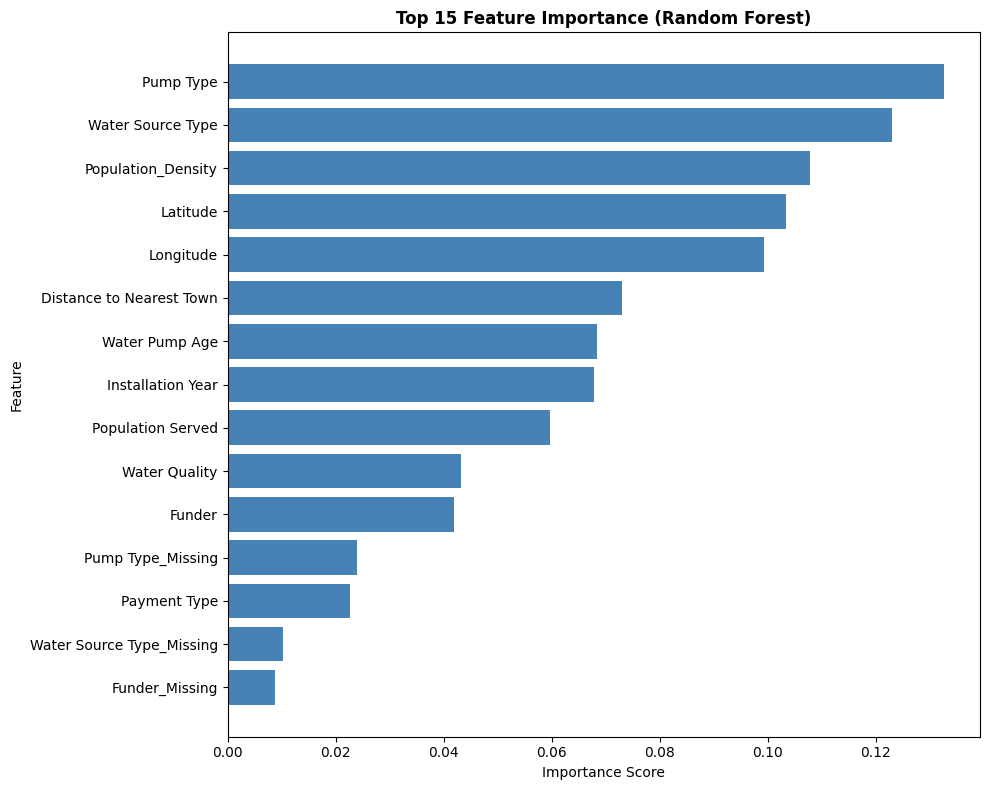

✓ Saved 'feature_importance.png' and 'feature_importance.csv'


In [48]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_results['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

feature_importance.to_csv('feature_importance.csv', index=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance.head(15)['Feature'],
         feature_importance.head(15)['Importance'],
         color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance (Random Forest)', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved 'feature_importance.png' and 'feature_importance.csv'")

Observation: Random Forest provides feature importance scores showing which variables most influence predictions. Higher scores indicate features that are more useful for splitting decisions across trees.

# CONFUSION MATRICES


Creating Confusion Matrices


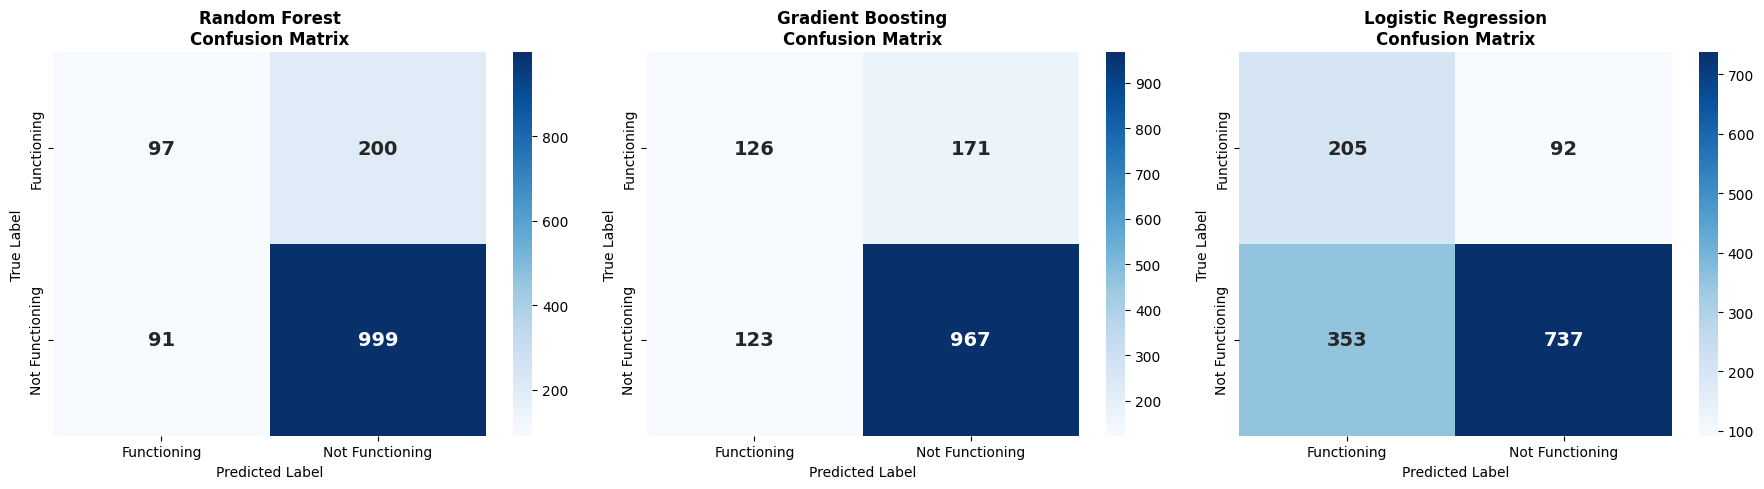

✓ Saved 'confusion_matrices.png'


In [49]:
print("\n" + "="*70)
print("Creating Confusion Matrices")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

top_models = [rf_results, gb_results, lr_results]
titles = ['Random Forest', 'Gradient Boosting', 'Logistic Regression']

for idx, (result, title) in enumerate(zip(top_models, titles)):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_,
                cbar=True, annot_kws={'size': 14, 'weight': 'bold'})
    axes[idx].set_title(f'{title}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved 'confusion_matrices.png'")


Observation : Random Forest prioritizes overall accuracy through strong majority class detection. Gradient Boosting offers a middle ground with decent accuracy and improved minority class detection. Logistic Regression provides the fairest predictions across both classes but with reduced overall accuracy.

# ROC CURVES


Creating ROC Curves


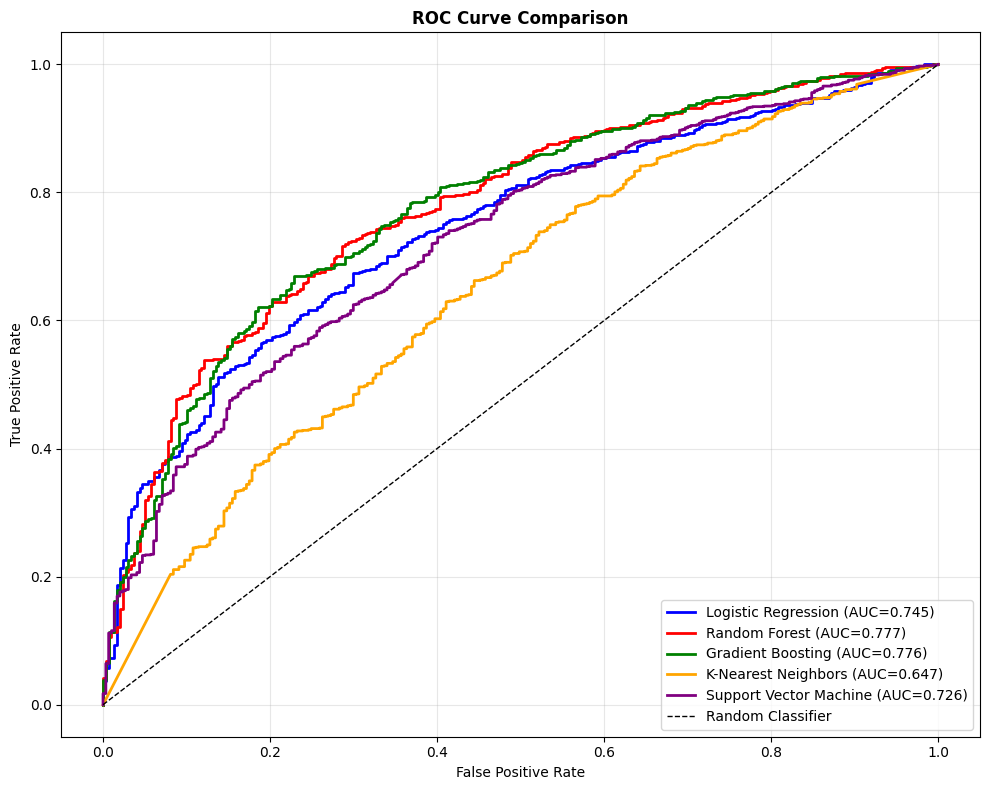

✓ Saved 'roc_curves.png'


In [ ]:
print("\n" + "="*70)
print("Creating ROC Curves")
print("="*70)

plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple']
for idx, result in enumerate([lr_results, rf_results, gb_results, knn_results, svm_results]):
    if result['pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['pred_proba'])
        auc = result['roc_auc']
        model_name_short = result['model_name'].replace('(Optimized)', '').strip()
        plt.plot(fpr, tpr, label=f"{model_name_short} (AUC={auc:.3f})",
                linewidth=2, color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved 'roc_curves.png'")


Observation: Random Forest and Gradient Boosting demonstrate superior classification performance (AUC ~0.78). Logistic Regression and SVM show moderate performance (AUC 0.72-0.75). KNN significantly underperforms (AUC 0.647), suggesting it's unsuitable for this imbalanced classification task.